# Coverage with Voronoi Partition (All Robots from One Side)
This simulation ensures all robots start from below the polygon but still move into the region by avoiding Voronoi flatness errors.
We apply Lloyd's algorithm to converge towards optimal coverage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation
from scipy.spatial import Voronoi
from shapely.geometry import Polygon as SPolygon

In [2]:
# Define convex polygon and density function Phi
polygon_vertices = np.array([[1, 0], [0.5, np.sqrt(3)/2], [-0.5, np.sqrt(3)/2],
                             [-1, 0], [-0.5, -np.sqrt(3)/2], [0.5, -np.sqrt(3)/2]])
def phi(x, y): return np.exp(-x**2 - y**2)
x = np.linspace(-1.5, 1.5, 300)
y = np.linspace(-2.0, 1.5, 300)
X, Y = np.meshgrid(x, y)
Z = phi(X, Y)

In [3]:
# Lloyd algorithm utilities
def clip_and_centroid(region, vertices, bounds):
    poly = SPolygon(bounds)
    if len(region) == 0 or -1 in region: return None
    pts = np.array([vertices[i] for i in region])
    try:
        vpoly = SPolygon(pts)
        clipped = vpoly.intersection(poly)
        if clipped.is_empty: return None
        return np.array(clipped.centroid.coords[0])
    except: return None

def lloyd_step(points, bounds):
    vor = Voronoi(points)
    new_points = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        centroid = clip_and_centroid(region, vor.vertices, bounds)
        new_points.append(centroid if centroid is not None else points[len(new_points)])
    return np.array(new_points)

In [4]:
# Initialize 15 robots along the bottom with slight Y noise to avoid flatness
np.random.seed(123)
num_robots = 15
x_positions = np.linspace(-0.9, 0.9, num_robots)
y_positions = np.full(num_robots, -0.85) + np.random.uniform(-0.01, 0.01, num_robots)
robot_positions = np.column_stack((x_positions, y_positions))
positions = [robot_positions.copy()]
for _ in range(100):
    positions.append(lloyd_step(positions[-1], polygon_vertices.tolist()))

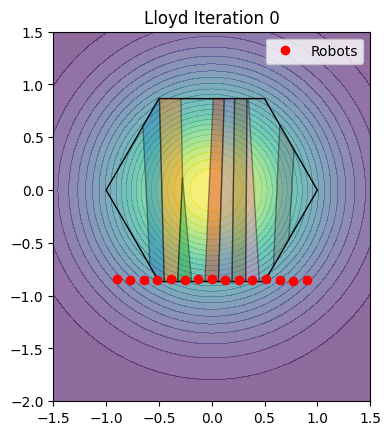

In [5]:
# Animate the process
fig, ax = plt.subplots()
def animate_entry(i):
    ax.clear()
    ax.set_title(f"Lloyd Iteration {i}")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-2.0, 1.5)
    ax.set_aspect('equal')
    ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.6)
    ax.add_patch(Polygon(polygon_vertices, closed=True, edgecolor='black', facecolor='none'))
    vor = Voronoi(positions[i])
    poly = SPolygon(polygon_vertices)
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if not region or -1 in region: continue
        poly_points = [vor.vertices[j] for j in region]
        try:
            region_poly = SPolygon(poly_points)
            clipped = region_poly.intersection(poly)
            if not clipped.is_empty and clipped.geom_type == 'Polygon':
                x, y = clipped.exterior.xy
                ax.fill(x, y, edgecolor='black', alpha=0.4)
        except: continue
    ax.plot(positions[i][:, 0], positions[i][:, 1], 'ro', label='Robots')
    ax.legend()
from IPython.display import HTML
ani = animation.FuncAnimation(fig, animate_entry, frames=len(positions), interval=300)
HTML(ani.to_jshtml())